In [18]:
from collections import deque
import math
import random

import keras
import gym
from matplotlib import pyplot as plt

env = gym.make('CartPole-v1')
REPLAY_MEMORY_SIZE = 1e5
OBSERVATION_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n
DISCOUNT_RATE = 0.99
EPSILON_MAX = 1.0
EPSILON_MIN = .01
ANNEALING_CONST = .001  # aka Lambda
MINIBATCH_SIZE = 64

class Memory(deque):
    def __init__(self, size):
        self.size = size

    def append(self, thing):
        if len(self) > self.size - 1:
            self.popleft()
        return super().append(thing)

    def sample(self, batch_size):
        batch_size = min(len(self), batch_size)
        return random.sample(self, batch_size)

q_network = keras.Sequential()
q_network.add(keras.layers.Dense(64, activation='relu', input_shape=OBSERVATION_SHAPE))
q_network.add(keras.layers.Dense(NUM_ACTIONS, activation='linear'))    
q_network.compile(optimizer=keras.optimizers.Adam(), loss='mse')
replay_memory = Memory(REPLAY_MEMORY_SIZE)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Note the relu vs linear activation functions for q_network.

In [ ]:
EPSILON = EPSILON_MAX

episode_count = 0
reward_hist = [] 
epsilon_hist = []
steps = 0
rand_act = []
q_net_act = []
RENDER = True

def replay():
    """
    I leaked scope here, wasted some time.
    """
    
    # Bec of the way we've set up the q_network, it gives us Vals for all actions available in one forward 
    # pass.    
    batch = replay_memory.sample(MINIBATCH_SIZE)

    # DON'T FORGET TO MAKE THESE ARRAYS... :/
    states = np.array([exp[0] for exp in batch])
    predictions = q_network.predict(states)

    terminal_state = np.zeros(OBSERVATION_SHAPE)
    states_ = np.array([exp[3] if exp[3] is not None else terminal_state for exp in batch])
    predictions_ = q_network.predict(states_)

    y = np.zeros((len(batch), NUM_ACTIONS))
    for idx, exp in enumerate(batch):
        state, action, reward, state_, terminal = exp
        target = predictions[idx]
        if state_ is None:
            target[action] = reward
        else:
            target[action] = reward + DISCOUNT_RATE * np.amax(predictions_[idx])
        y[idx] = target
    q_network.fit(states, y, batch_size=64, epochs=1, verbose=0)  # REMEBER, Q is a func from (state, action) pairs to values. 
    

while episode_count < 150:
    episode_done = False
    episode_reward = 0
    state = env.reset()
    episode_count += 1
    if episode_count % 10 == 0:
        print('Starting episode %s ' % episode_count)
    while not episode_done:
        EPSILON = EPSILON_MIN + (EPSILON_MAX - EPSILON_MIN) * math.exp(-ANNEALING_CONST * steps)
        epsilon_hist.append(EPSILON)
        steps += 1
        if random.random() < EPSILON:
            action = random.randint(0, NUM_ACTIONS-1)
            rand_act.append(1)
            q_net_act.append(0)
        else:
            # The hard-coded [0] is sketchy here
            action = q_network.predict(state.reshape((1, OBSERVATION_SHAPE[0]))).flatten().argmax()
            rand_act.append(0)
            q_net_act.append(1)

        state_, reward, episode_done, _ = env.step(action)
        episode_reward += reward
        if RENDER:
            env.render()
        if episode_done:
            state_ = None
        replay_memory.append((state, action, reward, state_, episode_done))
        replay()
        state = state_
        if episode_done:
            print(episode_reward)
            reward_hist.append(episode_reward)
            


25.0
16.0
13.0
33.0
40.0
18.0
27.0
10.0
11.0
Starting episode 10 
26.0
55.0
27.0
42.0
74.0
226.0
117.0
421.0
500.0
492.0
Starting episode 20 
324.0
500.0
482.0
500.0
414.0
500.0
487.0
423.0


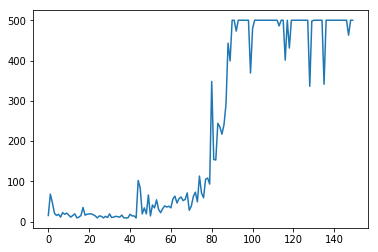

In [20]:
plt.plot(reward_hist)
plt.show()

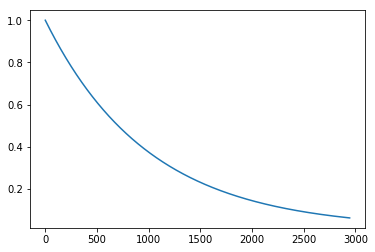

In [5]:
plt.plot(epsilon_hist)
plt.show()

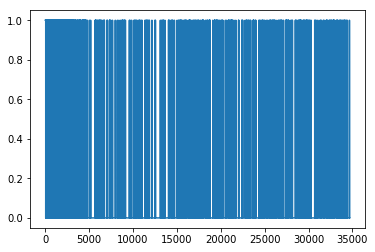

In [21]:
plt.plot(rand_act)
plt.show()


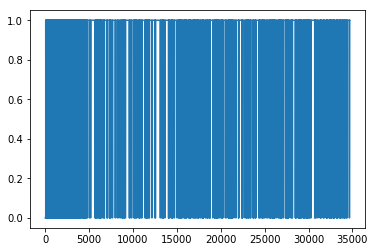

In [22]:
plt.plot(q_net_act)
plt.show()

In [8]:
print(sum(rand_act))
print(sum(q_net_act))

934
2012


In [13]:
len(replay_memory)

5399